Reading Data 

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


df = pd.read_excel("Churn-ModellingData.xlsx")

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


remove unnecessary columns

In [84]:
df.drop(["RowNumber","CustomerId"],inplace=True,axis=1)

Overview of the dataset and its main features

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  churned          10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


In [86]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
churned,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [87]:
df.isnull().any().any()

False

Data Visualizations

Text(0.5, 1.0, 'Age distribution graph')

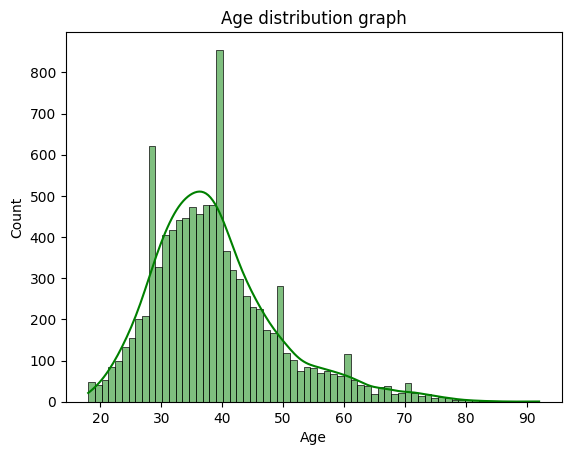

In [88]:
sns.histplot(data=df,x="Age",kde=True,color="green")
plt.title("Age distribution graph")


As can be seen from the graph showing the age distribution, there is almost a normal distribution, just a little skewed to the left. We see that there are people mostly around the age of 40.

<Axes: xlabel='Gender', ylabel='count'>

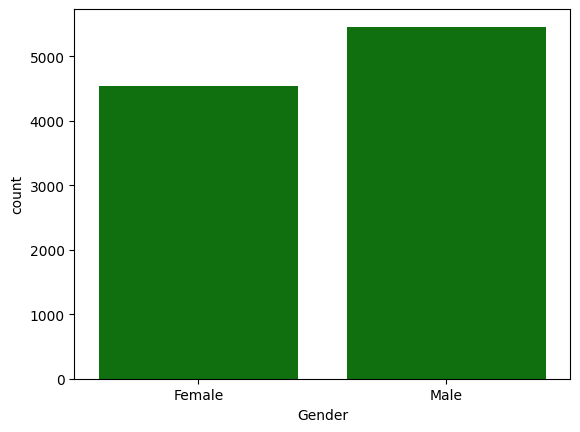

In [89]:
sns.countplot(data=df,x="Gender",color="Green")

There is a balanced distribution in gender distribution.

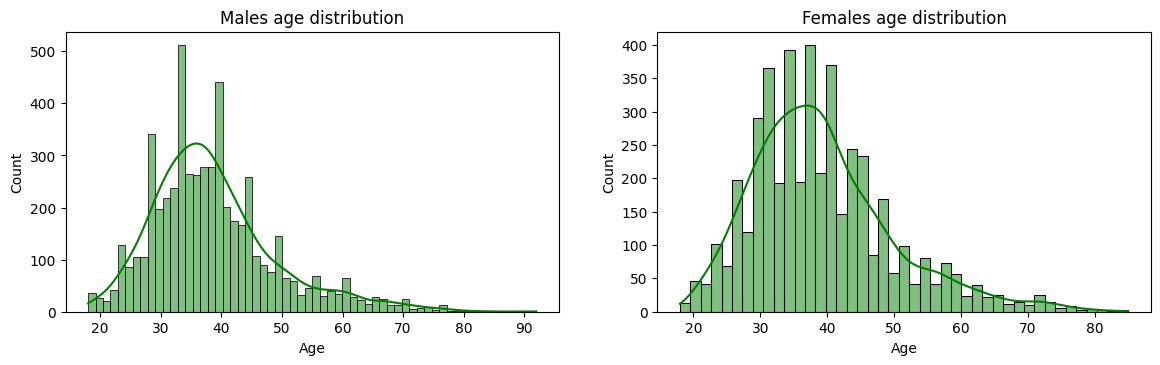

In [90]:
plt.figure(figsize=(14, 8))
plt.subplot(2,2,1)
sns.histplot(data=df[df["Gender"] == "Male"],x="Age",kde=True,color="green")
plt.title("Males age distribution")
plt.subplot(2,2,2)
sns.histplot(data=df[df["Gender"] == "Female"],x="Age",kde=True,color="green")
plt.title("Females age distribution");
plt.show()


Churned customers analysis

In [91]:
percentage_of_churned = (df[df["churned"] == 1].shape[0])*100/df.shape[0]
percentage_of_churned = format(percentage_of_churned,".1f")
print("Percentage of churned customers are %" + str(percentage_of_churned))

Percentage of churned customers are %20.4


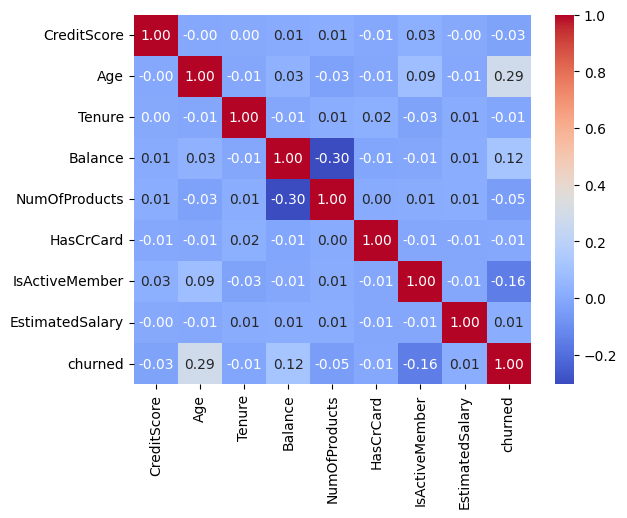

In [92]:
df_numeric = df.select_dtypes(include=[np.number])
sns.heatmap(df_numeric.corr(),annot=True,fmt=".2f", cmap='coolwarm');

In [93]:
churned_corr = pd.DataFrame(df_numeric.corr()["churned"])
churned_corr.drop("churned",axis=0,inplace=True)
churned_corr.sort_values("churned",ascending=False)

,churned
Age,0.285323
Balance,0.118533
EstimatedSalary,0.012097
HasCrCard,-0.007138
Tenure,-0.014001
CreditScore,-0.027094
NumOfProducts,-0.047820
IsActiveMember,-0.156128


C:\Users\Arda Öztüner\AppData\Local\Temp\ipykernel_12308\156673864.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churned_corr.index, y="churned", data=churned_corr, palette="viridis")


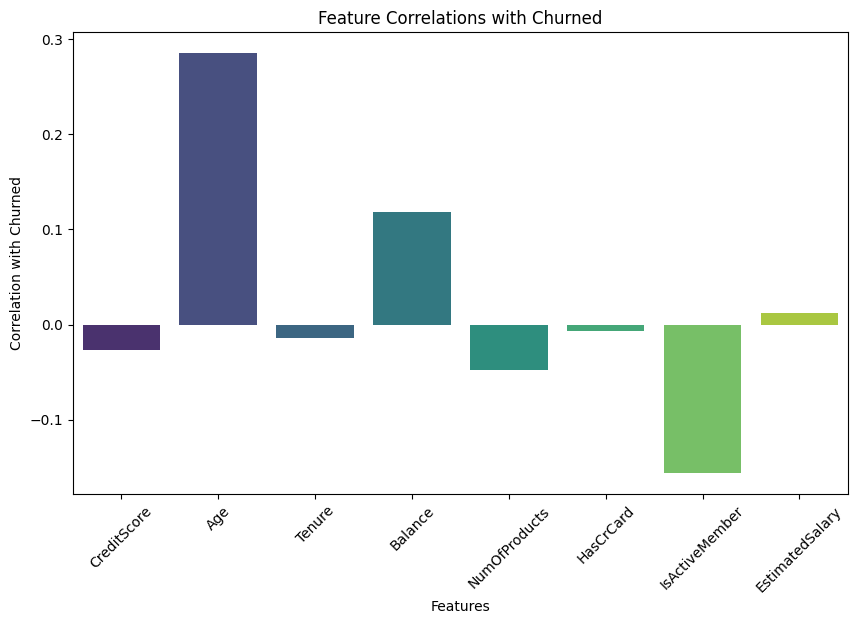

In [94]:
plt.figure(figsize=(10, 6))
sns.barplot(x=churned_corr.index, y="churned", data=churned_corr, palette="viridis")
plt.xticks(rotation=45)  
plt.xlabel("Features")
plt.ylabel("Correlation with Churned")
plt.title("Feature Correlations with Churned")
plt.show()

We understand from this that customers who churned are generally older customers. We can understand from this correlation graph that customers who are not actively working are also prone to leaving.

Geographical analysis

C:\Users\Arda Öztüner\AppData\Local\Temp\ipykernel_12308\2503147589.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Geography', y='NumOfProducts', data=df, palette='Pastel1')
C:\Users\Arda Öztüner\AppData\Local\Temp\ipykernel_12308\2503147589.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Geography', y='NumOfProducts', data=df, palette='Pastel2', inner='quartile')


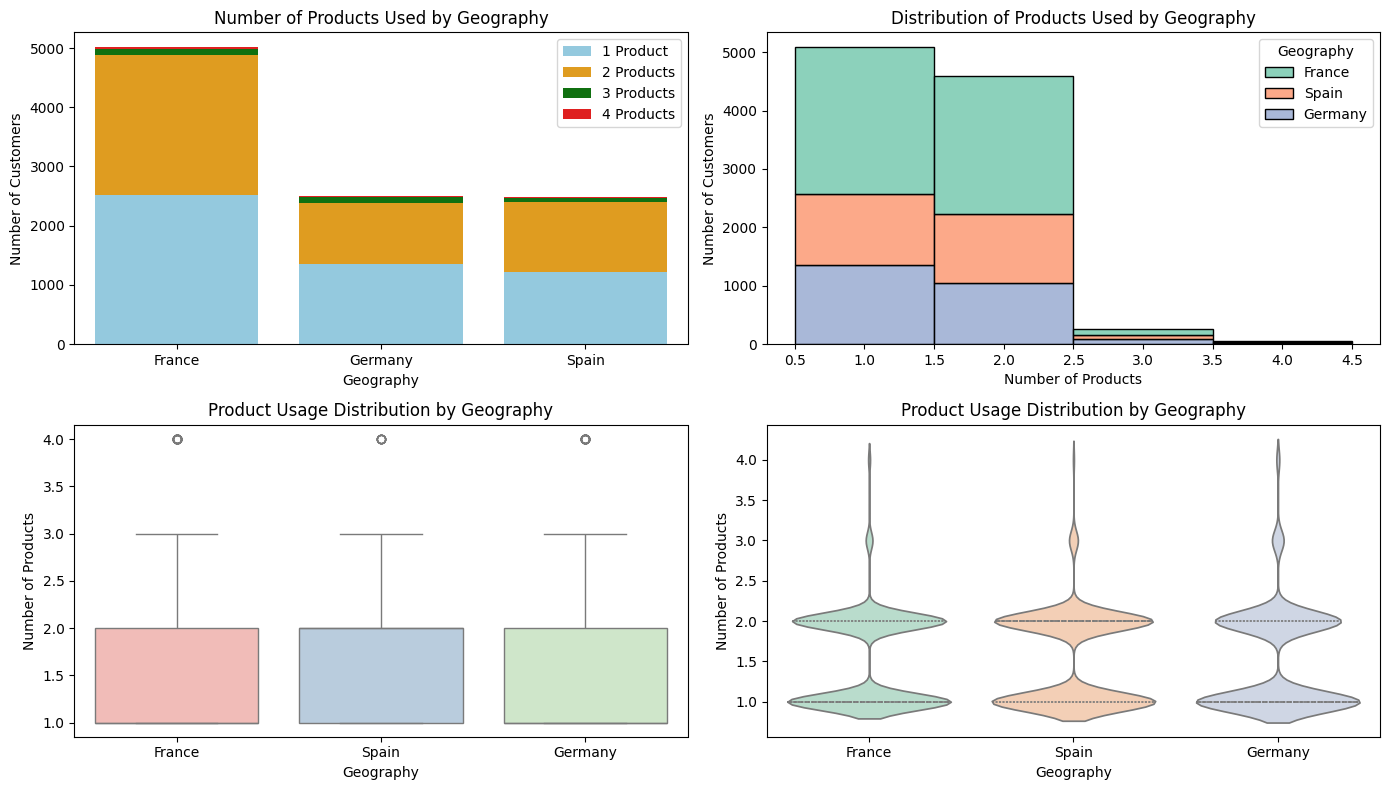

In [95]:
segment_counts = df.groupby('Geography')['NumOfProducts'].value_counts().unstack().fillna(0)

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.barplot(x=segment_counts.index, y=segment_counts[1], color='skyblue', label='1 Product')
sns.barplot(x=segment_counts.index, y=segment_counts[2], bottom=segment_counts[1], color='orange', label='2 Products')
sns.barplot(x=segment_counts.index, y=segment_counts[3], bottom=segment_counts[1] + segment_counts[2], color='green', label='3 Products')
sns.barplot(x=segment_counts.index, y=segment_counts[4], bottom=segment_counts[1] + segment_counts[2] + segment_counts[3], color='red', label='4 Products')
plt.ylabel('Number of Customers')
plt.title('Number of Products Used by Geography')
plt.legend()

plt.subplot(2, 2, 2)
sns.histplot(df, x='NumOfProducts', hue='Geography', multiple='stack', palette='Set2', bins=np.arange(1, 6)-0.5, edgecolor='black')
plt.xlabel('Number of Products')
plt.ylabel('Number of Customers')
plt.title('Distribution of Products Used by Geography')

plt.subplot(2, 2, 3)
sns.boxplot(x='Geography', y='NumOfProducts', data=df, palette='Pastel1')
plt.xlabel('Geography')
plt.ylabel('Number of Products')
plt.title('Product Usage Distribution by Geography')

plt.subplot(2, 2, 4)
sns.violinplot(x='Geography', y='NumOfProducts', data=df, palette='Pastel2', inner='quartile')
plt.xlabel('Geography')
plt.ylabel('Number of Products')
plt.title('Product Usage Distribution by Geography')

plt.tight_layout()
plt.show()

Analysis of age groups

C:\Users\Arda Öztüner\AppData\Local\Temp\ipykernel_12308\1347132966.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_counts = df.groupby('AgeGroup')['NumOfProducts'].value_counts().unstack().fillna(0)
C:\Users\Arda Öztüner\AppData\Local\Temp\ipykernel_12308\1347132966.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='AgeGroup', y='NumOfProducts', data=df, palette='Pastel1')
C:\Users\Arda Öztüner\AppData\Local\Temp\ipykernel_12308\1347132966.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns

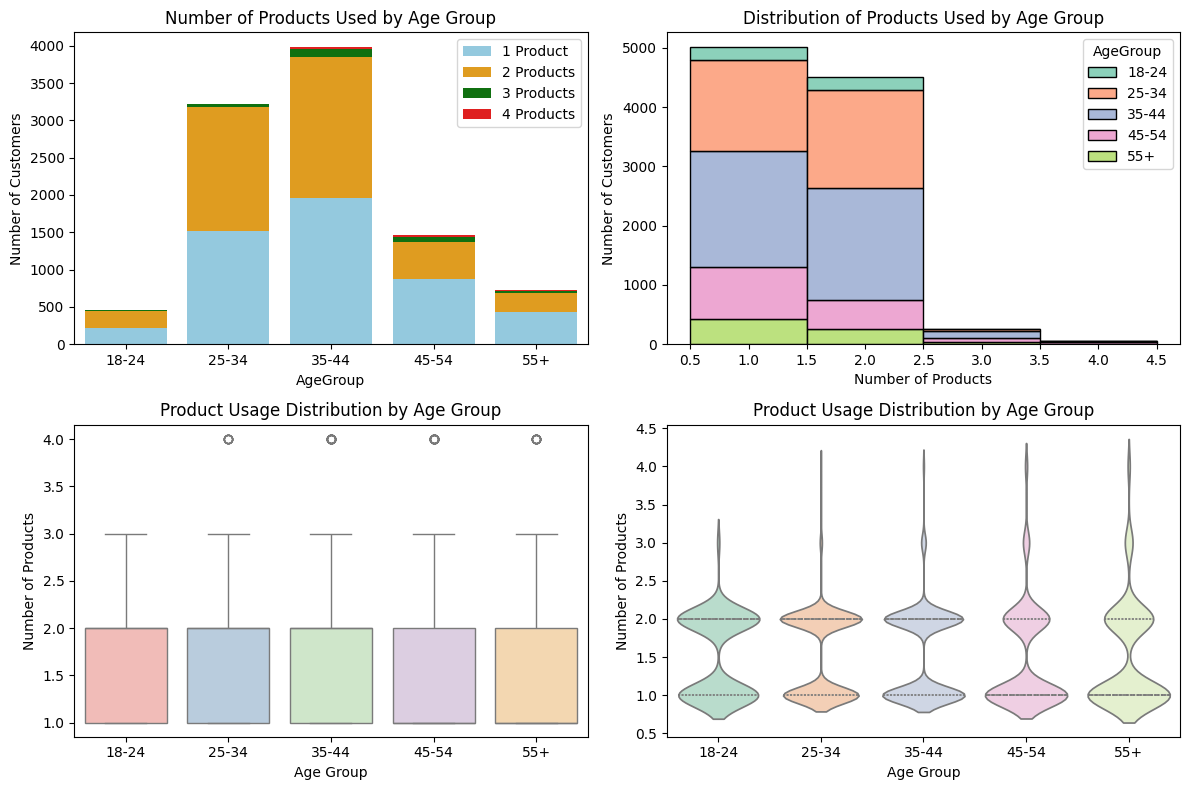

In [96]:
bins = [18, 25, 35, 45, 55, 70]
labels = ['18-24', '25-34', '35-44', '45-54', '55+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

segment_counts = df.groupby('AgeGroup')['NumOfProducts'].value_counts().unstack().fillna(0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.barplot(x=segment_counts.index, y=segment_counts[1], color='skyblue', label='1 Product')
sns.barplot(x=segment_counts.index, y=segment_counts[2], bottom=segment_counts[1], color='orange', label='2 Products')
sns.barplot(x=segment_counts.index, y=segment_counts[3], bottom=segment_counts[1] + segment_counts[2], color='green', label='3 Products')
sns.barplot(x=segment_counts.index, y=segment_counts[4], bottom=segment_counts[1] + segment_counts[2] + segment_counts[3], color='red', label='4 Products')
plt.ylabel('Number of Customers')
plt.title('Number of Products Used by Age Group')
plt.legend()

plt.subplot(2, 2, 2)
sns.histplot(df, x='NumOfProducts', hue='AgeGroup', multiple='stack', palette='Set2', bins=np.arange(1, 6)-0.5, edgecolor='black')
plt.xlabel('Number of Products')
plt.ylabel('Number of Customers')
plt.title('Distribution of Products Used by Age Group')

plt.subplot(2, 2, 3)
sns.boxplot(x='AgeGroup', y='NumOfProducts', data=df, palette='Pastel1')
plt.xlabel('Age Group')
plt.ylabel('Number of Products')
plt.title('Product Usage Distribution by Age Group')

plt.subplot(2, 2, 4)
sns.violinplot(x='AgeGroup', y='NumOfProducts', data=df, palette='Pastel2', inner='quartile')
plt.xlabel('Age Group')
plt.ylabel('Number of Products')
plt.title('Product Usage Distribution by Age Group')

plt.tight_layout()
plt.show()

Building Machine learning models to predict churned customers

In [97]:
df.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churned,AgeGroup
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,35-44
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,35-44
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,35-44
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,35-44
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,35-44


In [98]:
df.drop("AgeGroup",axis=1,inplace=True)
df.drop("Surname",axis=1,inplace=True)

In [99]:
# Applying one hot encoding transformation to the remaining variables except binary categorical variables.
df_encoded = pd.get_dummies(df,columns=["Geography"])


# Standardize numeric columns
ss = StandardScaler()

columns_to_standardize = ['CreditScore', 'Age',"Balance","Tenure","NumOfProducts","EstimatedSalary"]
df_encoded[columns_to_standardize] = ss.fit_transform(df_encoded[columns_to_standardize])


df_encoded["Gender"] = df_encoded["Gender"].map({"Female" : 0 , "Male" : 1})
df_encoded["Geography_France"] = df_encoded["Geography_France"].astype(int)
df_encoded["Geography_Germany"] = df_encoded["Geography_Germany"].astype(int)
df_encoded["Geography_Spain"] = df_encoded["Geography_Spain"].astype(int)

df_encoded.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churned,Geography_France,Geography_Germany,Geography_Spain
0,-0.326221,0,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,1,0,0
1,-0.440036,0,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,0,0,1
2,-1.536794,0,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,1,0,0
3,0.501521,0,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,1,0,0
4,2.063884,0,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,0,0,1


Splitting data

In [100]:

y = df_encoded["churned"].values
X = df_encoded.drop("churned",axis=1).values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=43)



### Machine Learning algorithms that we use : 

- Support Vector Machines
- Decision Tree
- Random Forest
- XGBoost 
- LightGBM
- KNN

###  1. Support Vector Machines

In [101]:


svm_rbf = SVC(kernel="rbf")
svm_linear = SVC(kernel="linear")
svm_poly = SVC(kernel="poly")
svm_sigmoid = SVC(kernel="sigmoid")

results = []

# RBF Kernel
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
report_rbf = classification_report(y_test, y_pred_rbf, output_dict=True)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
results.append(['RBF', report_rbf['accuracy'], report_rbf['weighted avg']['precision'], 
                report_rbf['weighted avg']['recall'], report_rbf['weighted avg']['f1-score']])

# Linear Kernel
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
report_linear = classification_report(y_test, y_pred_linear, output_dict=True)
accuracy_linear = accuracy_score(y_test, y_pred_linear)
results.append(['Linear', report_linear['accuracy'], report_linear['weighted avg']['precision'], 
                report_linear['weighted avg']['recall'], report_linear['weighted avg']['f1-score']])

# Polynomial Kernel
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
report_poly = classification_report(y_test, y_pred_poly, output_dict=True)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
results.append(['Polynomial', report_poly['accuracy'], report_poly['weighted avg']['precision'], 
                report_poly['weighted avg']['recall'], report_poly['weighted avg']['f1-score']])

# Sigmoid Kernel
svm_sigmoid.fit(X_train, y_train)
y_pred_sigmoid = svm_sigmoid.predict(X_test)
report_sigmoid = classification_report(y_test, y_pred_sigmoid, output_dict=True)
accuracy_sigmoid = accuracy_score(y_test, y_pred_sigmoid)
results.append(['Sigmoid', report_sigmoid['accuracy'], report_sigmoid['weighted avg']['precision'], 
                report_sigmoid['weighted avg']['recall'], report_sigmoid['weighted avg']['f1-score']])

df_results = pd.DataFrame(results, columns=['Kernel', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

df_results


C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_c

,Kernel,Accuracy,Precision,Recall,F1-Score
0,RBF,0.861333,0.857262,0.861333,0.841812
1,Linear,0.796333,0.634147,0.796333,0.706046
2,Polynomial,0.857333,0.853485,0.857333,0.835552
3,Sigmoid,0.704333,0.690669,0.704333,0.697166


In [102]:
# Calculate accuracy scores for each SVM kernel on the train set
train_accuracy_rbf = accuracy_score(y_train, svm_rbf.predict(X_train))
train_accuracy_linear = accuracy_score(y_train, svm_linear.predict(X_train))
train_accuracy_poly = accuracy_score(y_train, svm_poly.predict(X_train))
train_accuracy_sigmoid = accuracy_score(y_train, svm_sigmoid.predict(X_train))

# Calculate accuracy scores for each SVM kernel on the test set
test_accuracy_rbf = accuracy_score(y_test, svm_rbf.predict(X_test))
test_accuracy_linear = accuracy_score(y_test, svm_linear.predict(X_test))
test_accuracy_poly = accuracy_score(y_test, svm_poly.predict(X_test))
test_accuracy_sigmoid = accuracy_score(y_test, svm_sigmoid.predict(X_test))

# Create a DataFrame to store the results
results = {
    'Kernel': ['RBF', 'Linear', 'Polynomial', 'Sigmoid'],
    'Train Accuracy': [train_accuracy_rbf, train_accuracy_linear, train_accuracy_poly, train_accuracy_sigmoid],
    'Test Accuracy': [test_accuracy_rbf, test_accuracy_linear, test_accuracy_poly, test_accuracy_sigmoid]
}

results_df = pd.DataFrame(results)

results_df

,Kernel,Train Accuracy,Test Accuracy
0,RBF,0.865429,0.861333
1,Linear,0.796286,0.796333
2,Polynomial,0.861714,0.857333
3,Sigmoid,0.695000,0.704333


Text(0.5, 1.0, 'Sigmoid Kernel confusion matrix')

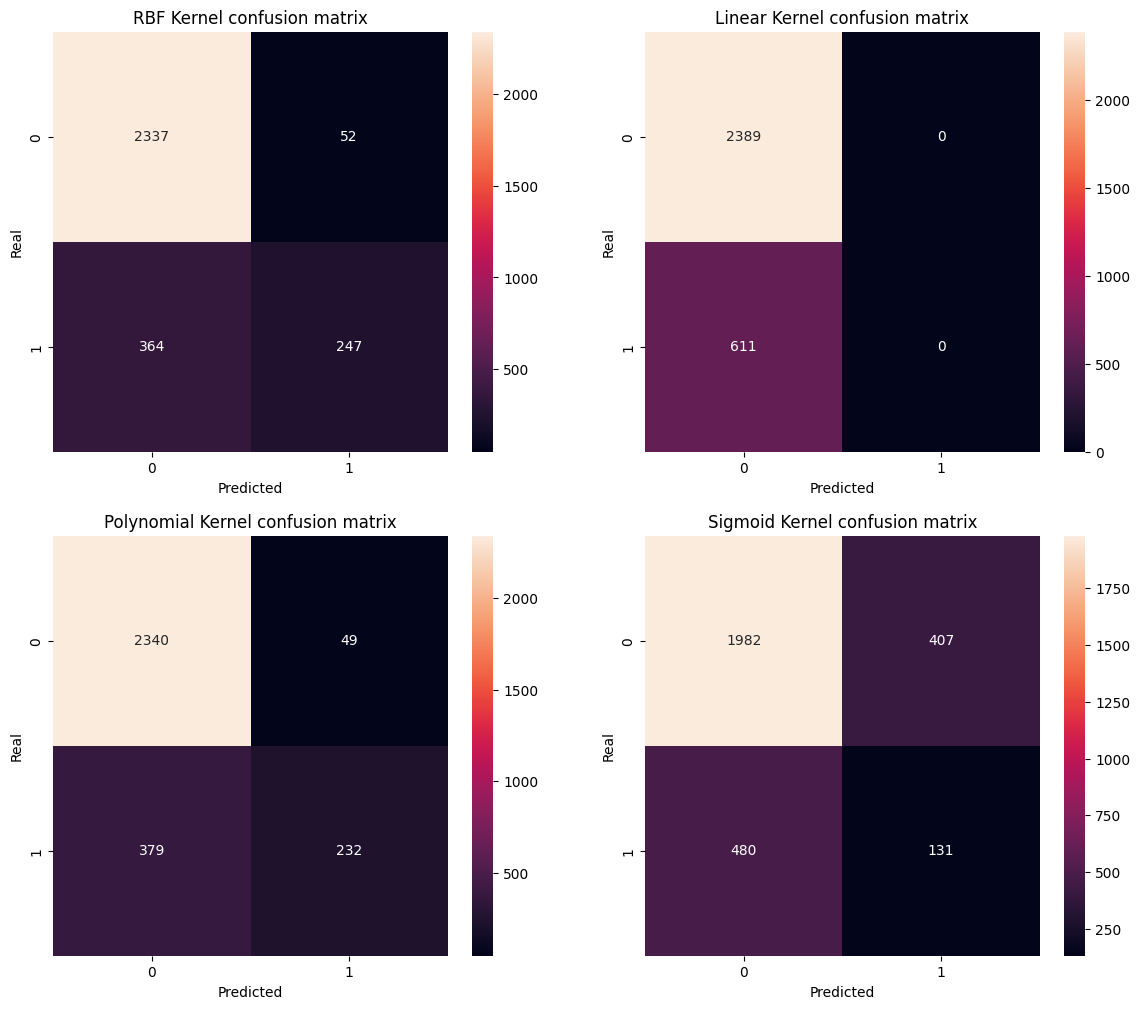

In [103]:
plt.figure(figsize=(14, 12))

plt.subplot(2,2,1)
sns.heatmap(confusion_matrix(y_test,svm_rbf.predict(X_test)),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("RBF Kernel confusion matrix")

plt.subplot(2,2,2)

sns.heatmap(confusion_matrix(y_test,svm_linear.predict(X_test)),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Linear Kernel confusion matrix")

plt.subplot(2,2,3)

sns.heatmap(confusion_matrix(y_test,svm_poly.predict(X_test)),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Polynomial Kernel confusion matrix")

plt.subplot(2,2,4)

sns.heatmap(confusion_matrix(y_test,svm_sigmoid.predict(X_test)),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Sigmoid Kernel confusion matrix")

### 2. Decision Tree

In [104]:


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(1, 11)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}


clf = DecisionTreeClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_model_dt = grid_search.best_estimator_



C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
990 fits failed out of a total of 2970.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
990 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

In [105]:
print(best_model_dt.get_params())



{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [106]:
y_head_dt = best_model_dt.predict(X_test)

print(classification_report(y_test,y_head_dt))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2389
           1       0.64      0.39      0.48       611

    accuracy                           0.83      3000
   macro avg       0.75      0.67      0.69      3000
weighted avg       0.81      0.83      0.81      3000



In [107]:
results = []

report_df = classification_report(y_test, y_head_dt, output_dict=True)
dt_accuracy = accuracy_score(y_test, y_head_dt)
results.append(['Decision Tree', report_rbf['accuracy'], report_rbf['weighted avg']['precision'], 
                report_rbf['weighted avg']['recall'], report_rbf['weighted avg']['f1-score']])

df_results_dt = pd.DataFrame(results, columns=['Metrics', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

df_results_dt.T


,0
Metrics,Decision Tree
Accuracy,0.861333
Precision,0.857262
Recall,0.861333
F1-Score,0.841812


In [108]:
train_accuracy_dt = accuracy_score(y_train, best_model_dt.predict(X_train))

results = {
    'Algorithm': ['Decision Tree'],
    'Train Accuracy': [train_accuracy_dt],
    'Test Accuracy': [dt_accuracy]
}

train_results_dt = pd.DataFrame(results)

train_results_dt

,Algorithm,Train Accuracy,Test Accuracy
0,Decision Tree,0.839,0.830667


#### 3. Random Forest

In [109]:

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True],
    'class_weight': [None]
}

clf = RandomForestClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_model_rf = grid_search.best_estimator_


C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0

In [110]:
y_head_rf = best_model_rf.predict(X_test)

print(classification_report(y_test,y_head_rf))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.77      0.47      0.58       611

    accuracy                           0.86      3000
   macro avg       0.82      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000



In [111]:
results = []

report_rf = classification_report(y_test, y_head_rf, output_dict=True)
rf_accuracy = accuracy_score(y_test, y_head_rf)
results.append(['Random Forest', report_rf['accuracy'], report_rf['weighted avg']['precision'], 
                report_rf['weighted avg']['recall'], report_rf['weighted avg']['f1-score']])

df_results_rf = pd.DataFrame(results, columns=['Metrics', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

df_results_rf.T

,0
Metrics,Random Forest
Accuracy,0.862667
Precision,0.854042
Recall,0.862667
F1-Score,0.849169


In [112]:
train_accuracy_rf = accuracy_score(y_train, best_model_rf.predict(X_train))

results = {
    'Algorithm': ['Random Forest'],
    'Train Accuracy': [train_accuracy_rf],
    'Test Accuracy': [rf_accuracy]
}

train_results_rf = pd.DataFrame(results)

train_results_rf

,Algorithm,Train Accuracy,Test Accuracy
0,Random Forest,0.973857,0.862667


#### 4. XGBoost

In [113]:


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)

grid_search.fit(X_train, y_train)

best_model_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [22:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [22:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Arda Öztüner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\co

In [114]:
y_head_xgb = best_model_xgb.predict(X_test)

print(classification_report(y_test,y_head_xgb))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.76      0.50      0.60       611

    accuracy                           0.87      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000



In [115]:
results = []

report_xgb = classification_report(y_test, y_head_xgb, output_dict=True)
xgb_accuracy = accuracy_score(y_test, y_head_xgb)
results.append(['XGBoost', report_xgb['accuracy'], report_xgb['weighted avg']['precision'], 
                report_xgb['weighted avg']['recall'], report_xgb['weighted avg']['f1-score']])

df_results_xgb = pd.DataFrame(results, columns=['Metrics', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

df_results_xgb.T

,0
Metrics,XGBoost
Accuracy,0.866
Precision,0.857429
Recall,0.866
F1-Score,0.855185


In [116]:
train_accuracy_xgb = accuracy_score(y_train, best_model_xgb.predict(X_train))

results = {
    'Algorithm': ['XGBoost'],
    'Train Accuracy': [train_accuracy_xgb],
    'Test Accuracy': [xgb_accuracy]
}

train_results_xgb = pd.DataFrame(results)

train_results_xgb

,Algorithm,Train Accuracy,Test Accuracy
0,XGBoost,0.895,0.866


#### 5. LightGBM

In [117]:


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


lgb_model = lgb.LGBMClassifier()

grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)

grid_search.fit(X_train, y_train)

best_model_gbm = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[LightGBM] [Info] Number of positive: 950, number of negative: 3716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 4666, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203601 -> initscore=-1.363941
[LightGBM] [Info] Start training from score -1.363941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [118]:
y_head_gbm = best_model_gbm.predict(X_test)

print(classification_report(y_test,y_head_gbm))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.75      0.49      0.59       611

    accuracy                           0.86      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000



In [119]:
results = []

report_gbm = classification_report(y_test, y_head_gbm, output_dict=True)
gbm_accuracy = accuracy_score(y_test, y_head_gbm)
results.append(['LightGBM', report_gbm['accuracy'], report_gbm['weighted avg']['precision'], 
                report_gbm['weighted avg']['recall'], report_gbm['weighted avg']['f1-score']])

df_results_gbm = pd.DataFrame(results, columns=['Metrics', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

df_results_gbm.T

,0
Metrics,LightGBM
Accuracy,0.862667
Precision,0.853432
Recall,0.862667
F1-Score,0.851171


In [120]:
train_accuracy_gbm = accuracy_score(y_train, best_model_gbm.predict(X_train))

results = {
    'Algorithm': ['LightGBM'],
    'Train Accuracy': [train_accuracy_gbm],
    'Test Accuracy': [gbm_accuracy]
}

train_results_xgb = pd.DataFrame(results)

train_results_xgb

,Algorithm,Train Accuracy,Test Accuracy
0,LightGBM,0.890286,0.862667


#### 5. KNN

In [121]:

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1: manhattan_distance, p=2: euclidean_distance
}

knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)

grid_search.fit(X_train, y_train)

best_model_knn = grid_search.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [122]:
y_head_knn = best_model_knn.predict(X_test)

print(classification_report(y_test,y_head_knn))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2389
           1       0.72      0.43      0.53       611

    accuracy                           0.85      3000
   macro avg       0.79      0.69      0.72      3000
weighted avg       0.84      0.85      0.83      3000



In [123]:
results = []

report_knn = classification_report(y_test, y_head_knn, output_dict=True)
knn_accuracy = accuracy_score(y_test, y_head_knn)
results.append(['KNN', report_knn['accuracy'], report_knn['weighted avg']['precision'], 
                report_knn['weighted avg']['recall'], report_knn['weighted avg']['f1-score']])

df_results_knn = pd.DataFrame(results, columns=['Metrics', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

df_results_knn.T

,0
Metrics,KNN
Accuracy,0.849
Precision,0.836657
Recall,0.849
F1-Score,0.833419


In [124]:
final_results = pd.concat([df_results_dt,df_results_rf,df_results_xgb,df_results_gbm,df_results_knn])
final_results = final_results.reset_index()
final_results.drop("index",axis=1,inplace=True)
final_results.sort_values("Accuracy",ascending=False,ignore_index=True)

,Metrics,Accuracy,Precision,Recall,F1-Score
0,XGBoost,0.866000,0.857429,0.866000,0.855185
1,Random Forest,0.862667,0.854042,0.862667,0.849169
2,LightGBM,0.862667,0.853432,0.862667,0.851171
3,Decision Tree,0.861333,0.857262,0.861333,0.841812
4,KNN,0.849000,0.836657,0.849000,0.833419


# Bonus: Deap Learning Algorithms

### Artificial Neural Network, ANN

In [125]:


model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),  
    Dense(64, activation='relu'),  
    Dense(1, activation='sigmoid')  
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history  = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.4275 - accuracy: 0.8136 - val_loss: 0.3763 - val_accuracy: 0.8477
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.3577 - accuracy: 0.8510 - val_loss: 0.3560 - val_accuracy: 0.8577
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.3462 - accuracy: 0.8549 - val_loss: 0.3521 - val_accuracy: 0.8603
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.3408 - accuracy: 0.8576 - val_loss: 0.3453 - val_accuracy: 0.8577
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.3364 - accuracy: 0.8607 - val_loss: 0.3475 - val_accuracy: 0.8593
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.3337 - accuracy: 0.8601 - val_loss: 0.3523 - val_accuracy: 0.8570
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.3310 - accuracy: 0.8610 - val_loss: 0.3453 - val_accuracy: 0.8583
Epoch 

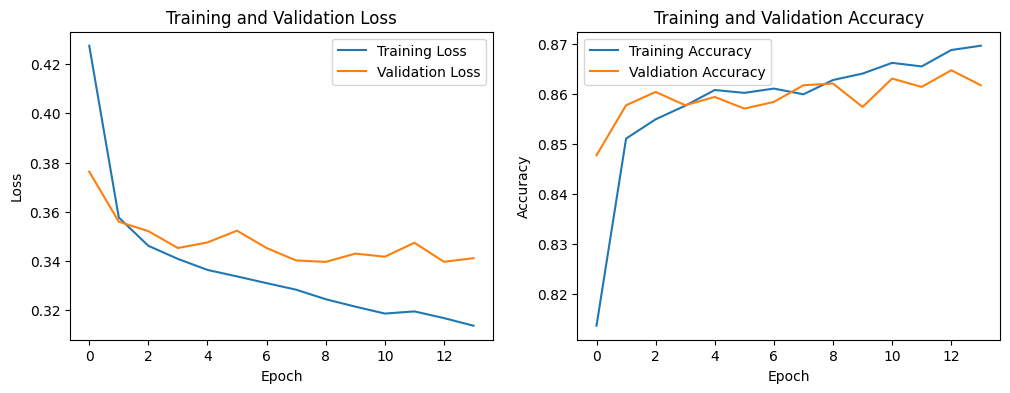

In [126]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Valdiation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [127]:
y_pred_ANN = (model.predict(X_test) > 0.5).astype("int32")


print(classification_report(y_test, y_pred_ANN))

94/94 [==============================] - 0s 796us/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      2389
           1       0.74      0.50      0.60       611

    accuracy                           0.86      3000
   macro avg       0.81      0.73      0.76      3000
weighted avg       0.85      0.86      0.85      3000



Text(50.722222222222214, 0.5, 'Real')

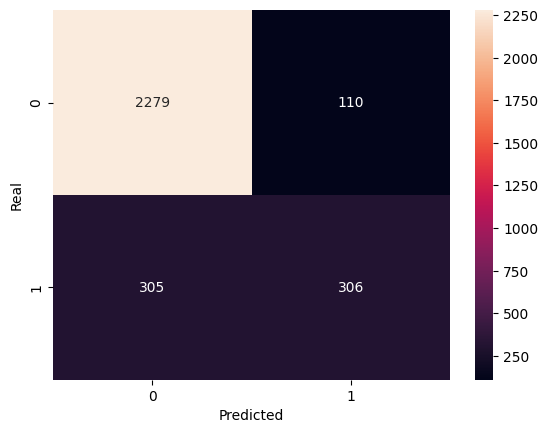

In [128]:
sns.heatmap(confusion_matrix(y_test,y_pred_ANN),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Real")

## Fully Connected Deep Neural Network (DNN):

In [129]:


model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),  
    Dense(128, activation='relu'),  
    Dense(64, activation='relu'),   
    Dense(32, activation='relu'),   
    Dense(1, activation='sigmoid')  
])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.4050 - accuracy: 0.8210 - val_loss: 0.3925 - val_accuracy: 0.8503
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.3540 - accuracy: 0.8534 - val_loss: 0.3518 - val_accuracy: 0.8593
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.3431 - accuracy: 0.8571 - val_loss: 0.3506 - val_accuracy: 0.8557
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.3354 - accuracy: 0.8601 - val_loss: 0.3409 - val_accuracy: 0.8623
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.3325 - accuracy: 0.8607 - val_loss: 0.3376 - val_accuracy: 0.8640
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.3253 - accuracy: 0.8636 - val_loss: 0.3511 - val_accuracy: 0.8510
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.3238 - accuracy: 0.8647 - val_loss: 0.3561 - val_accuracy: 0.8583
Epoch 

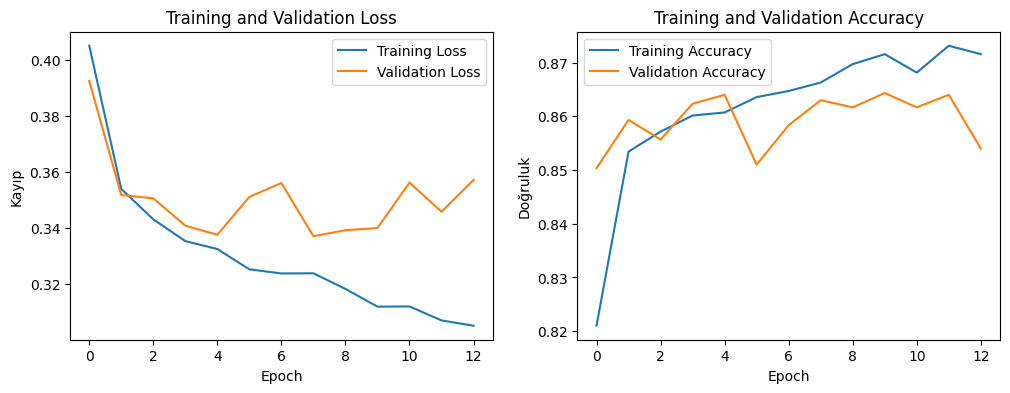

In [130]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()


In [131]:
y_pred_DNN = (model.predict(X_test) > 0.5).astype("int32")

print("Classification Report:\n", classification_report(y_test, y_pred_DNN))



94/94 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      2389
           1       0.67      0.55      0.60       611

    accuracy                           0.85      3000
   macro avg       0.78      0.74      0.76      3000
weighted avg       0.85      0.85      0.85      3000



Text(50.722222222222214, 0.5, 'Real')

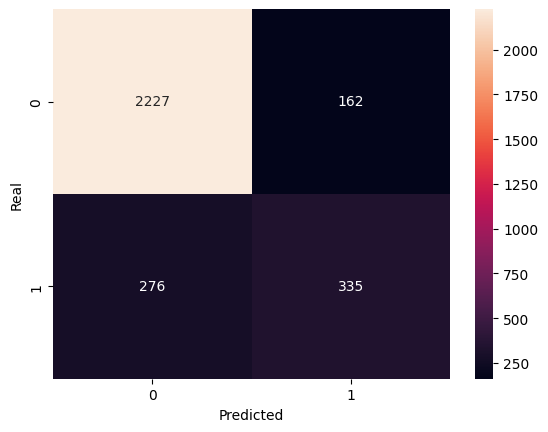

In [132]:
sns.heatmap(confusion_matrix(y_test,y_pred_DNN),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Real")